In [1]:
from msclap import CLAP
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
original_df = pd.read_csv("/bucket/data_collection/datasets/web_free_data/source/youtube_children_podcasts_122023/meta_annotated.csv")
df = original_df[['filepath']]

In [40]:
classes = ['child', 'adult']

class_id_map = {name: i for i, name in enumerate(classes, 0)}
id_class_map =  {v: k for k, v in class_id_map.items()}
print(class_id_map, id_class_map)

prompt = 'The speaker is a'
y = [prompt + x for x in classes]



{'child': 0, 'adult': 1} {0: 'child', 1: 'adult'}


In [41]:
# Load and initialize CLAP
clap_model = CLAP(version = '2023', use_cuda=True)

# Computing text embeddings
text_embeddings = clap_model.get_text_embeddings(y)

In [42]:
# Computing audio embeddings
y_preds, y_labels = [], []
print(os.getcwd())

for i in tqdm(range(len(df))):
    path = df.iloc[i][0]


    #idx = class_id_map[label]
    #one_hot_target = torch.nn.functional.one_hot(torch.tensor([idx]), num_classes=len(classes)+1)

    audio_embeddings = clap_model.get_audio_embeddings([path], resample=True)
    similarity = clap_model.compute_similarity(audio_embeddings, text_embeddings)

    y_pred = F.softmax(similarity.detach().cpu(), dim=1).numpy()

    y_preds.append(y_pred)
    #y_labels.append(one_hot_target.detach().cpu().numpy())


/mounts/ud-data/jtaylor/a5f2c23d-7fb6-41a6-ac0c-3a2ffc02b992/data/acoustic_scene_classification/CLAP-main/examples/child_speech_classification


  0%|          | 2/60150 [00:00<52:11, 19.21it/s]

100%|██████████| 60150/60150 [35:52<00:00, 27.94it/s]  


In [43]:
y_pred = np.concatenate(y_preds, axis=0)
y_pred_val = np.argmax(y_pred, axis=1)

predictions = [id_class_map[pred] for pred in y_pred_val]
df['prediction'] = predictions

confidence = [y_preds[k][0][y_pred_val[k]] for k, pred in enumerate(y_preds)] 
df['confidence'] = confidence

display(df)

,filepath,prediction,confidence
0,/bucket/data_collection/datasets/web_free_data...,child,0.822018
1,/bucket/data_collection/datasets/web_free_data...,child,0.815935
2,/bucket/data_collection/datasets/web_free_data...,adult,0.610423
3,/bucket/data_collection/datasets/web_free_data...,adult,0.574910
4,/bucket/data_collection/datasets/web_free_data...,adult,0.652934
...,...,...,...
60145,/bucket/data_collection/datasets/web_free_data...,child,0.789549
60146,/bucket/data_collection/datasets/web_free_data...,child,0.604048
60147,/bucket/data_collection/datasets/web_free_data...,child,0.853177
60148,/bucket/data_collection/datasets/web_free_data...,child,0.705883


In [47]:
original_df['model_prediction'] = original_df['model_prediction'].str.replace('kid', 'child')

In [44]:
original_df['model_prediction_v2'] = df['prediction']
original_df['model_confidence_v2'] = df['confidence']


In [48]:
display(original_df)
original_df.to_csv('ytchildpod_modelprediction_v2.csv')

,item_id,filename,dstFilename,filepath,srcFilename,total_annotators,annotator_id,file_length,sample_rate,match_type,main_type,sub_type,tag,reveberation,tag_freq,model_prediction,model_confidence,model_prediction_v2,model_confidence_v2
0,7168806,00000002.wav,/bucket/data_collection/datasets/web_free_data...,/bucket/data_collection/datasets/web_free_data...,/bucket/data_collection/datasets/web_free_data...,3,"101,103,99",4.0,48000,Hard Match,mixed,other,children speech,med,"{'children speech': 2, 'chlidren speech': 1}",child,0.652816,child,0.822018
1,7168809,00000003.wav,/bucket/data_collection/datasets/web_free_data...,/bucket/data_collection/datasets/web_free_data...,/bucket/data_collection/datasets/web_free_data...,3,"103,99,101",4.0,48000,Hard Match,mixed,other,children speech,med,"{'chlidren speech': 1, 'children speech': 2}",child,0.833740,child,0.815935
2,7168812,00000004.wav,/bucket/data_collection/datasets/web_free_data...,/bucket/data_collection/datasets/web_free_data...,/bucket/data_collection/datasets/web_free_data...,3,"101,103,99",4.0,48000,Hard Match,mixed,other,children speech,med,"{'children speech': 2, 'chlidren speech': 1}",adult,0.679938,adult,0.610423
3,7168814,00000005.wav,/bucket/data_collection/datasets/web_free_data...,/bucket/data_collection/datasets/web_free_data...,/bucket/data_collection/datasets/web_free_data...,3,"103,99,101",4.0,48000,Hard Match,mixed,other,children speech,low,"{'chlidren speech': 1, 'children speech': 2}",child,0.638220,adult,0.574910
4,7168817,00000006.wav,/bucket/data_collection/datasets/web_free_data...,/bucket/data_collection/datasets/web_free_data...,/bucket/data_collection/datasets/web_free_data...,3,"101,103,99",4.0,48000,Hard Match,mixed,other,children speech,low,"{'children speech': 2, 'chlidren speech': 1}",adult,0.520470,adult,0.652934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60145,7220570,00060345.wav,/bucket/data_collection/datasets/web_free_data...,/bucket/data_collection/datasets/web_free_data...,/bucket/data_collection/datasets/web_free_data...,2,"86,81",4.0,48000,Soft Match (no common tag),mixed,other,female speech,high,{'female speech': 1},adult,0.585711,child,0.789549
60146,7220571,00060346.wav,/bucket/data_collection/datasets/web_free_data...,/bucket/data_collection/datasets/web_free_data...,/bucket/data_collection/datasets/web_free_data...,2,"86,81",4.0,48000,Soft Match (no common tag),mixed,other,female speech,high,{'female speech': 1},child,0.506952,child,0.604048
60147,7220572,00060347.wav,/bucket/data_collection/datasets/web_free_data...,/bucket/data_collection/datasets/web_free_data...,/bucket/data_collection/datasets/web_free_data...,2,"86,81",4.0,48000,Soft Match (no common tag),mixed,other,female speech,high,{'female speech': 1},child,0.626496,child,0.853177
60148,7220573,00060348.wav,/bucket/data_collection/datasets/web_free_data...,/bucket/data_collection/datasets/web_free_data...,/bucket/data_collection/datasets/web_free_data...,2,"86,81",4.0,48000,Soft Match (no common tag),mixed,other,female speech,high,{'female speech': 1},child,0.638529,child,0.705883


In [2]:
original_df = pd.read_csv('ytchildpod_modelprediction_v2.csv')
print('tag isNA:', original_df['tag'].isna().sum())
print('tag isNA, predicted child by v1:', len(original_df[(original_df['tag'].isna()) & (original_df['model_prediction']=='child')]))
print('tag isNA, predicted child by v2:', len(original_df[(original_df['tag'].isna()) & (original_df['model_prediction_v2']=='child')]))
print('tag isNA, predicted child by both:', len(original_df[(original_df['tag'].isna()) & (original_df['model_prediction']=='child') & (original_df['model_prediction_v2']=='child')]))

nan_but_child_df = original_df[(original_df['tag'].isna()) & (original_df['model_prediction']=='child') & (original_df['model_prediction_v2']=='child')]

adult_tag_list = ['female speech', 'male speech']
print(f'\ntag is in {adult_tag_list}:', original_df['tag'].isin(adult_tag_list).sum())
print(f'tag is in {adult_tag_list}, predicted child by v1:', len(original_df[(original_df['tag'].isin(adult_tag_list)) & (original_df['model_prediction']=='child')]))
print(f'tag is in {adult_tag_list}, predicted child by v2:', len(original_df[(original_df['tag'].isin(adult_tag_list)) & (original_df['model_prediction_v2']=='child')]))
print(f'tag is in {adult_tag_list}, predicted child by both:', len(original_df[(original_df['tag'].isin(adult_tag_list)) & (original_df['model_prediction']=='child') & (original_df['model_prediction_v2']=='child')]))

adult_but_child_df = original_df[(original_df['tag'].isin(adult_tag_list)) & (original_df['model_prediction']=='child') & (original_df['model_prediction_v2']=='child')]

tag isNA: 49845
tag isNA, predicted child by v1: 3674
tag isNA, predicted child by v2: 5445
tag isNA, predicted child by both: 3441

tag is in ['female speech', 'male speech']: 3901
tag is in ['female speech', 'male speech'], predicted child by v1: 145
tag is in ['female speech', 'male speech'], predicted child by v2: 348
tag is in ['female speech', 'male speech'], predicted child by both: 131


In [9]:
nan_but_child_df['filepath'].sample(20).to_csv('nan_but_child_list.txt', index=False, header=False)

In [10]:
adult_but_child_df['filepath'].sample(20).to_csv('adult_but_child_list.txt', index=False, header=False)

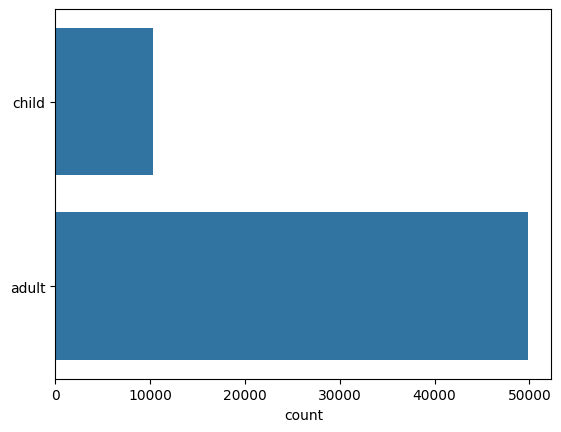

In [46]:
sns.countplot(predictions)
plt.show()

In [37]:
y_lab, y_pred = np.concatenate(y_labels, axis=0), np.concatenate(y_preds, axis=0)
y_label_val = np.argmax(y_lab, axis=1)
y_pred_val = np.argmax(y_pred, axis=1)
acc = accuracy_score(np.argmax(y_lab, axis=1), np.argmax(y_pred, axis=1))
print('Accuracy {}'.format(acc))

Accuracy 0.556


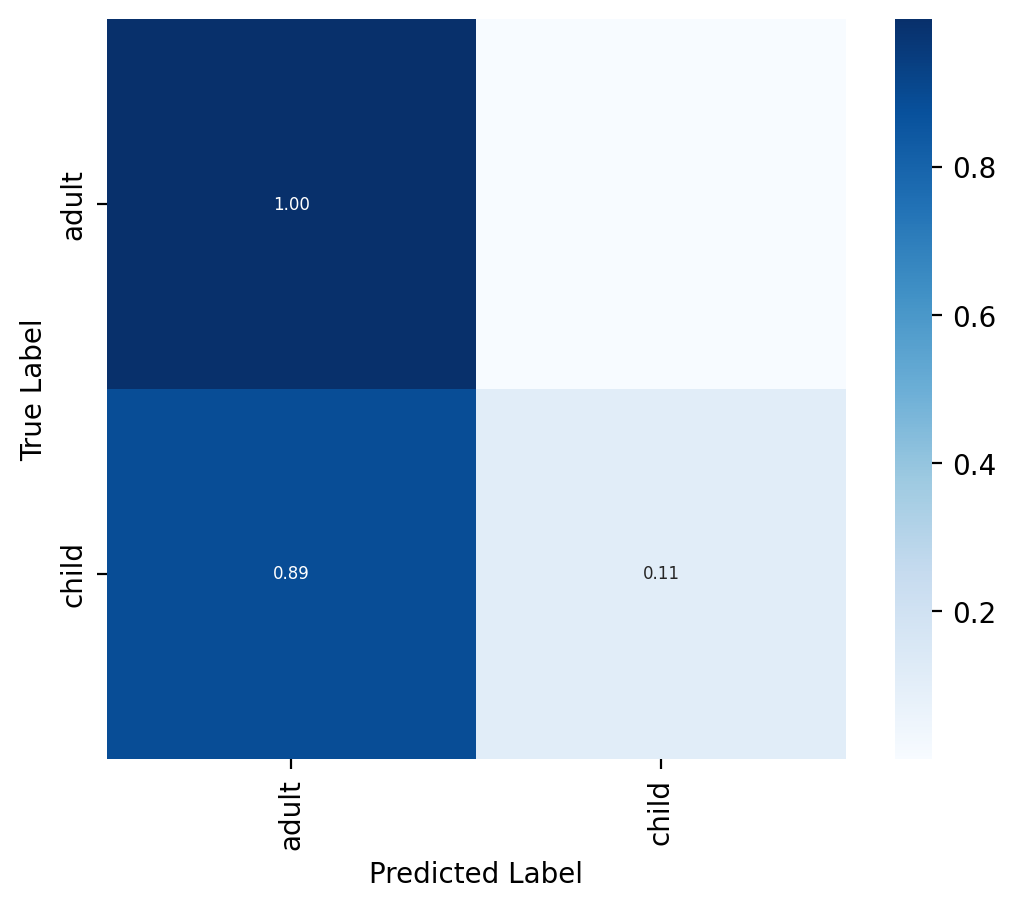

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# get confusion matrix
conf_matrix = confusion_matrix(y_label_val,y_pred_val)
conf_mat_norm_recall = conf_matrix.astype('float32')/conf_matrix.sum(axis=1)[:,np.newaxis]
recall_by_class = np.diagonal(conf_mat_norm_recall)
mean_recall = np.mean(recall_by_class)

# Calculate row sums to use for percentages
row_sums = conf_matrix.sum(axis=1)

# Calculate percentages
percentages = (conf_matrix.T / row_sums).T  # Transpose for division, then transpose back

# Format percentages as strings with '%' symbol
annot_data = [['{:.2f}'.format(val) for val in row] for row in percentages]
annot_data = [['' if float(val <= 0.04) else '{:.2f}'.format(val) for val in row] for row in percentages]

plt.figure(dpi=200)

annot_kws = {'size': 6}
ax = sns.heatmap(percentages, xticklabels=classes, yticklabels=classes, annot=annot_data, fmt='', square=True, cmap='Blues', annot_kws=annot_kws)
ax.set_xlabel('Predicted Label')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_ylabel('True Label')

#plt.subplots_adjust(left=0.2, bottom=0.35)
plt.show()